# Imports

In [ ]:
%pip install seaborn

In [ ]:
%pip install tweepy

In [ ]:
%pip install autocorrect

In [ ]:
%pip install spacy

In [ ]:
%pip install nltk

In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tweepy
import pickle
import nltk
from nltk.tokenize import wordpunct_tokenize
from autocorrect import Speller
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
import spacy
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [ ]:
# nltk.download('stopwords')

# Set up Twitter API

In [32]:
api_key = "Uroihphf25vaDmGPadvG1klrU"
api_secret_key = "mpQ6yDaGmdiyPW6ytzEo5nrw8SZn94YZKtMnx3tx13RQj7HoYs"
bearer_token = "AAAAAAAAAAAAAAAAAAAAAORhNAEAAAAAR1ODpBlt9PHGImWMWE8WxxfRHhY%3D0UDIDDI9ARsdZzFo4Pf7jrVdlIdzgqz1CDWcoYCGdm42jieyLR"
access_token = "889954860329730048-7mBJQPfciA1pva5Olpovd22deE8hplo"
access_token_secret = "FGy9LvHHZt6X6W1umPugGlgPJsdWpUjH9Eu4re9ozxNEz"

auth = tweepy.OAuthHandler(api_key, api_secret_key)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

# Grab user profiles

In [35]:
# use multiple categories so that we can actually see the efficacy of our rec system
queries = [
    "neuroscience",
    "machine learning",
    "education",
    "medicine",
    "movies",
    "entertainment",
    "finance",
    "business",
    "fitness"
]
n_profs = 3
username_map = {}
for q in queries:
    username_map[q] = np.random.choice(np.unique([user.screen_name for user in api.search_users(q)]),size=3,replace=False)

# get profiles
profiles = []
for cat in username_map:
    users = username_map[cat]
    for user in users:
        try:
            profiles.append(api.get_user(user).description)
        except:
            print(f"Error for user {name}, removing")
            username_map[cat].remove(user)
            
# all usernames
usernames = np.ravel(list(username_map.values()))

# user-category pairs
cat_map = {user:cat for cat in username_map for user in usernames if user in username_map[cat]}

# Process profile data

In [43]:
def remove_words_with_char(char: str, sentence: str):
    return " ".join(filter(lambda x:x[0]!=char, sentence.split()))

In [51]:
# tokenize, conver to lower case, remove non words and stop words, autocorrect
spell = Speller()
stop_words = np.unique(stopwords.words('english') + ["the"])
proc_profiles = []
for prof in profiles:
    # remove anything with @ in front
    tokens = wordpunct_tokenize(remove_words_with_char("@",prof))
    processed_profile = []
    for word in tokens:
        cleaned_word = spell(word.lower())
        if cleaned_word.isalpha() and cleaned_word not in stop_words:
            processed_profile.append(cleaned_word)
    proc_profiles.append(processed_profile)

# Explore profile data

In [55]:
print("Mean length of profile:", int(np.mean([len(prof) for prof in proc_profiles])), "words")

Mean length of profile: 12 words


In [56]:
# most common words
all_words = np.hstack(proc_profiles)
freq = nltk.FreqDist(all_words)
sorted_freq = {k: v for k, v in sorted(freq.items(), key=lambda item: item[1])[::-1]}

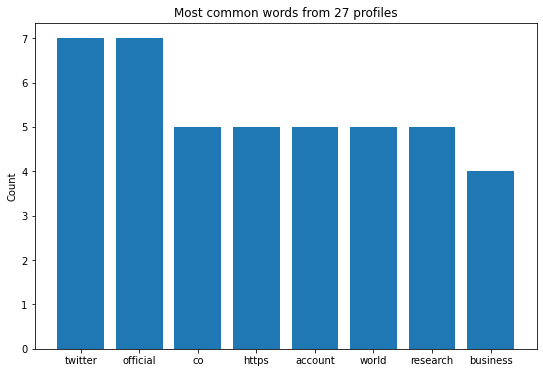

In [57]:
num_words = 8
fig,ax = plt.subplots(1,1,figsize=(9,6))
ax.bar(np.arange(num_words), list(sorted_freq.values())[:num_words])
ax.set_xticks(np.arange(num_words))
ax.set_xticklabels(list(sorted_freq.keys())[:num_words])
ax.set_ylabel("Count")
ax.set_title(f"Most common words from {len(proc_profiles)} profiles")
plt.show()

In [58]:
# unique words
print("# of unique words:",len(set(all_words)))

# of unique words: 260


# One-hot vector model

In [59]:
onehot_dict = {}
for word in all_words:
    onehot_dict[word] = np.zeros(len(usernames))
    
onehot_df = pd.DataFrame(onehot_dict,index=usernames)
for prof,(idx,row) in zip(proc_profiles,onehot_df.iterrows()):
    for word in prof:
        onehot_df.loc[idx,word] = 1

onehot_df

,international,interdisciplinary,scientific,non,profit,society,annual,meeting,online,feb,...,shares,trustworthy,weight,loss,tips,approachable,workout,recipes,latest,trends
S4SNeuro,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NeuroscienceNew,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Neurosci2019,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JmlrOrg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MLStreetTalk,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
slashML,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PhCHED,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACEducation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EdNCES,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
IcahnMountSinai,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


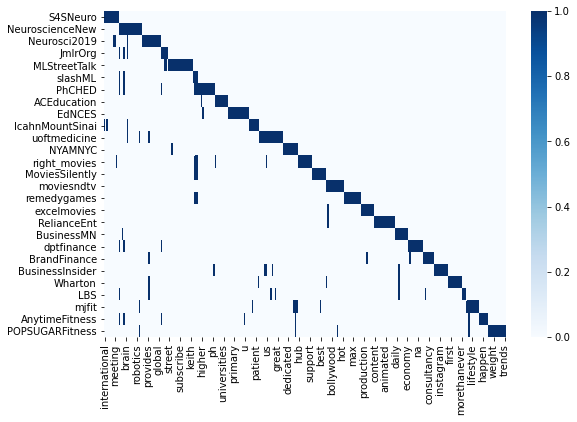

In [60]:
plt.figure(figsize=(9,6))
sns.heatmap(onehot_df,cmap="Blues")
plt.show()

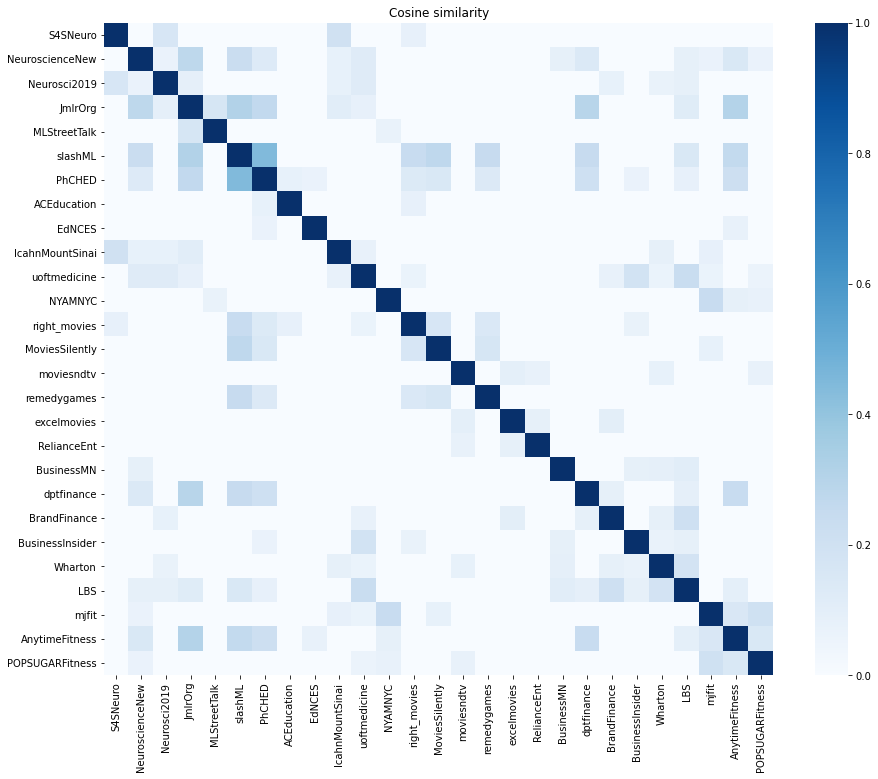

In [61]:
# compute similarity
cos_similarity = cosine_similarity(onehot_df.to_numpy())
plt.figure(figsize=(15,12))
sns.heatmap(cos_similarity,cmap="Blues",xticklabels=usernames,yticklabels=usernames)
plt.title("Cosine similarity")
plt.show()

In [62]:
def similarity_rankings(users, similarity_scores, num_recs: int=5) -> pd.DataFrame:
    user_recs_dict = {"user":[],"recommendation":[],"score":[], "ranking":[]}
    for i,user in enumerate(users):
        # get sim scores and remove current user
        curr_sim_scores = np.delete(similarity_scores[i].copy(),i)
        curr_users = np.delete(np.array(users.copy()),i)
        # get recs
        for i in range(num_recs):
            user_recs_dict["user"].append(user)
            # current most similar user and score
            top_sim_idx = np.argmax(curr_sim_scores)
            top_sim_user = curr_users[top_sim_idx]
            top_sim_score = curr_sim_scores[top_sim_idx]
            user_recs_dict["recommendation"].append(top_sim_user)
            user_recs_dict["score"].append(top_sim_score)
            user_recs_dict["ranking"].append(i+1)
            # remove from lists
            curr_sim_scores = np.delete(curr_sim_scores,top_sim_idx)
            curr_users = np.delete(curr_users,top_sim_idx)

    user_recs = pd.DataFrame.from_dict(user_recs_dict)
    return user_recs

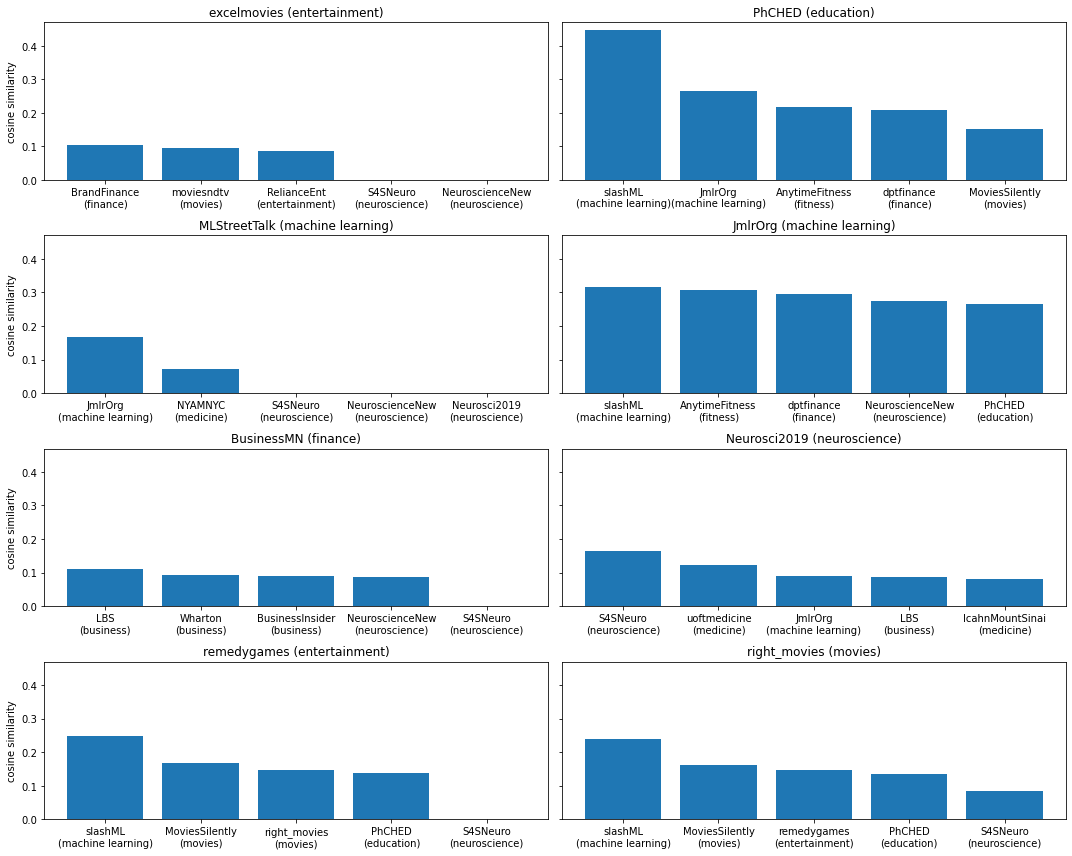

In [78]:
cos_user_recs = similarity_rankings(usernames, cos_similarity)
rand_users = np.random.choice(usernames,size=8,replace=False)
fig,axes = plt.subplots(4,2,figsize=(15,12),sharey=True)
for i,(user,ax) in enumerate(zip(rand_users,np.ravel(axes))):
    curr_user = cos_user_recs[cos_user_recs["user"]==user]
    recs = curr_user.recommendation
    recs_w_cat = [rec_user+f"\n({cat_map[rec_user]})" for rec_user in recs]
    ax.bar(recs_w_cat,curr_user.score)
    ax.set_title(f"{user} ({cat_map[user]})")
    ax.set_ylabel("cosine similarity") if not i%2 else ax.set_ylabel("")
plt.tight_layout()
plt.show()

# SpaCy word embedding model
- trained on 685 unique vectors with 300 dimensions

In [74]:
nlp = spacy.load("en_core_web_lg")

In [75]:
# turn tokenized profiles back into full sentence to embed
full_profiles = [" ".join(prof) for prof in proc_profiles]

# calculate average word embedding for each profile
ave_embeddings = np.array([nlp(prof).vector for prof in full_profiles])

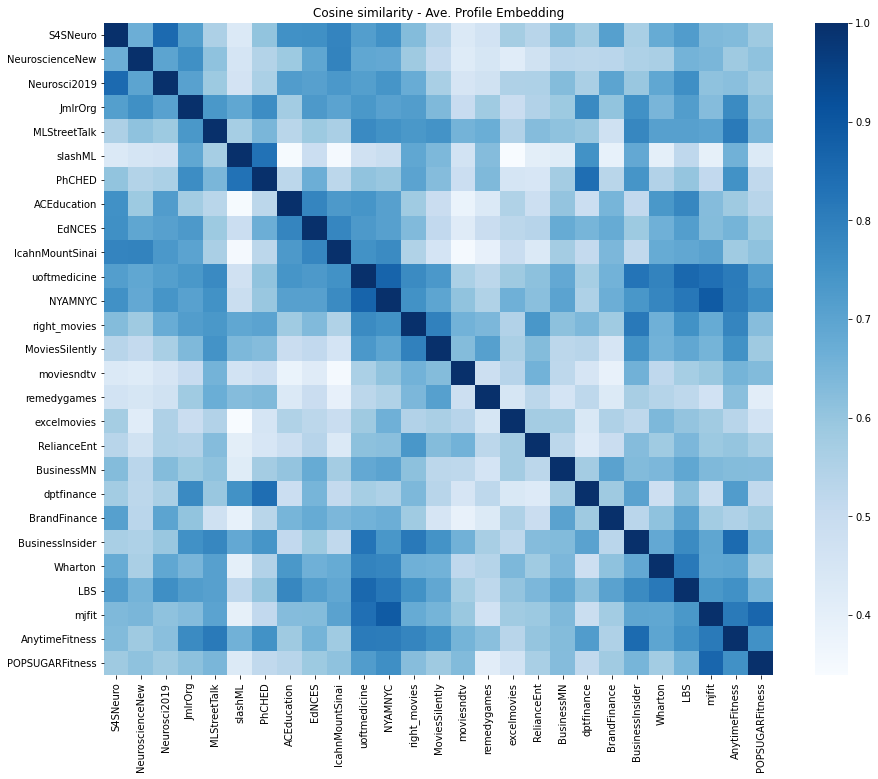

In [77]:
# compute similarity
embed_cos_similarity = cosine_similarity(ave_embeddings)
plt.figure(figsize=(15,12))
sns.heatmap(embed_cos_similarity,cmap="Blues",xticklabels=usernames,yticklabels=usernames)
plt.title("Cosine similarity - Ave. Profile Embedding")
plt.show()

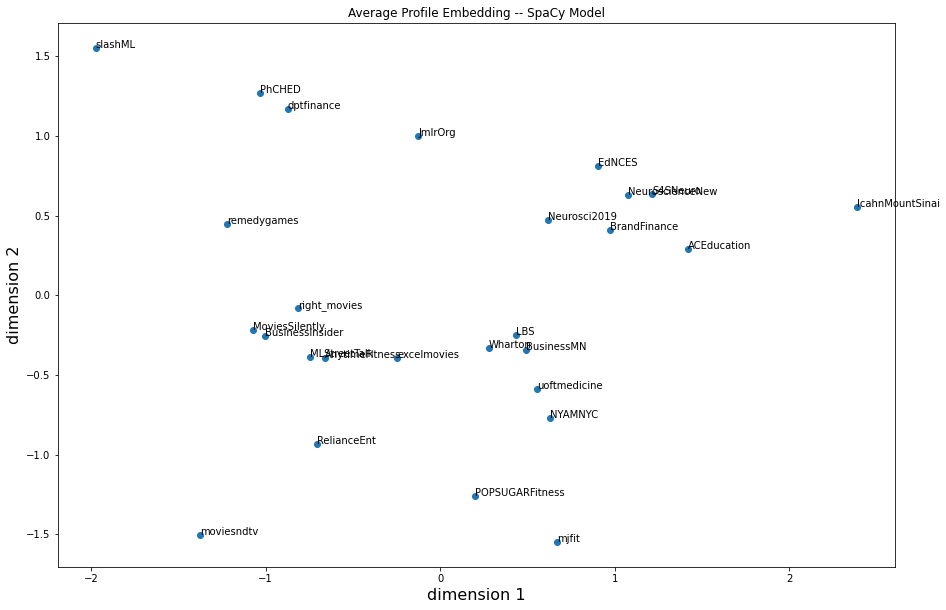

In [206]:
# visualize ave. profile embeddings
pca = PCA(n_components=2)
embed_2d = pca.fit_transform(ave_embeddings)

plt.figure(figsize=(15,10))
plt.scatter(embed_2d[:, 0], embed_2d[:, 1])
for i, user in enumerate(usernames):
    plt.annotate(user, xy=(embed_2d[i, 0], embed_2d[i, 1]))
plt.xlabel("dimension 1",fontsize=16)
plt.ylabel("dimension 2",fontsize=16)
plt.title("Average Profile Embedding -- SpaCy Model")
plt.show()

In [176]:
all_pairs = pd.DataFrame({
    "user1":[],
    "user2":[],
    "profile1":[],
    "profile2":[],
    "category1":[],
    "category2":[],
    "similarity":[]
})
for user,prof,embed in zip(usernames,full_profiles,ave_embeddings):
    for other_user,other_prof,other_embed in zip(usernames,profiles,ave_embeddings):
        if (other_user == user):
            continue
        new_row = pd.DataFrame()
        new_row["user1"] = [user]
        new_row["user2"] = [other_user]
        new_row["profile1"] = [prof]
        new_row["profile2"] = [other_prof]
        new_row["category1"] = [cat_map[user]]
        new_row["category2"] = [cat_map[other_user]]
        new_row["similarity"] = [cosine_similarity(embed.reshape(1,-1),other_embed.reshape(1,-1))[0].item()]
        all_pairs = all_pairs.append(new_row,ignore_index=True)
all_pairs

,user1,user2,profile1,profile2,category1,category2,similarity
0,S4SNeuro,NeuroscienceNew,international interdisciplinary scientific non...,Official Neuroscience News Twitter. Brain rese...,neuroscience,neuroscience,0.668724
1,S4SNeuro,Neurosci2019,international interdisciplinary scientific non...,Oct. 19–23 in Chicago. SfN's annual meeting pr...,neuroscience,neuroscience,0.851418
2,S4SNeuro,JmlrOrg,international interdisciplinary scientific non...,Official twitter account for the Journal of Ma...,neuroscience,machine learning,0.714929
3,S4SNeuro,MLStreetTalk,international interdisciplinary scientific non...,Machine Learning Street Talk! New Episodes eve...,neuroscience,machine learning,0.558217
4,S4SNeuro,slashML,international interdisciplinary scientific non...,Official Twitter Feed For https://t.co/5qp68DBh9K,neuroscience,machine learning,0.433845
...,...,...,...,...,...,...,...
697,POPSUGARFitness,BusinessInsider,popular fitness shares trustworthy weight loss...,What you want to know about business. A sectio...,fitness,business,0.650779
698,POPSUGARFitness,Wharton,popular fitness shares trustworthy weight loss...,"Wharton School of @Penn, the world's first col...",fitness,business,0.579123
699,POPSUGARFitness,LBS,popular fitness shares trustworthy weight loss...,Official tweets from one of the world's leadin...,fitness,business,0.649639
700,POPSUGARFitness,mjfit,popular fitness shares trustworthy weight loss...,The best in men's #training #fitness #nutritio...,fitness,fitness,0.861206


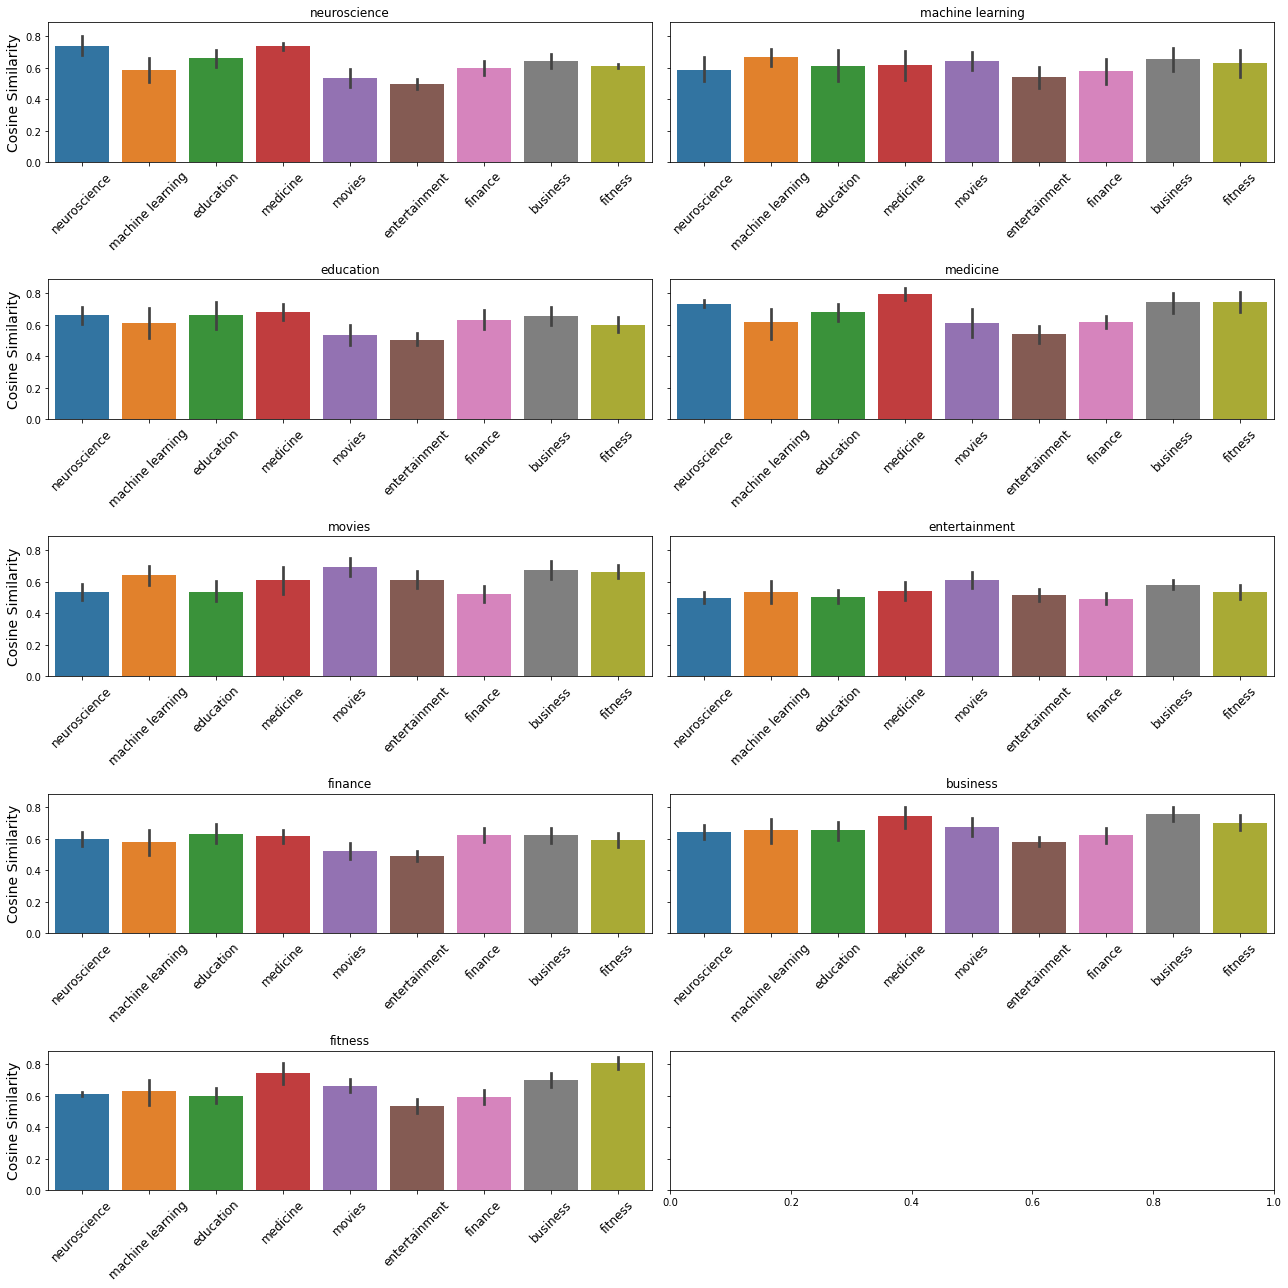

In [177]:
# visualize results
fig,axes = plt.subplots(5,2,figsize=(18,18),sharey=True)
for i,(cat,ax) in enumerate(zip(queries,np.ravel(axes))):
    sns.barplot(data=all_pairs[all_pairs["category1"]==cat],x="category2",y="similarity",ax=ax)
    ax.set_title(cat)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45,fontsize=12)
    ax.set_xlabel("")
    ax.set_ylabel("Cosine Similarity",fontsize=14) if not i%2 else ax.set_ylabel("")
plt.tight_layout()
plt.show()

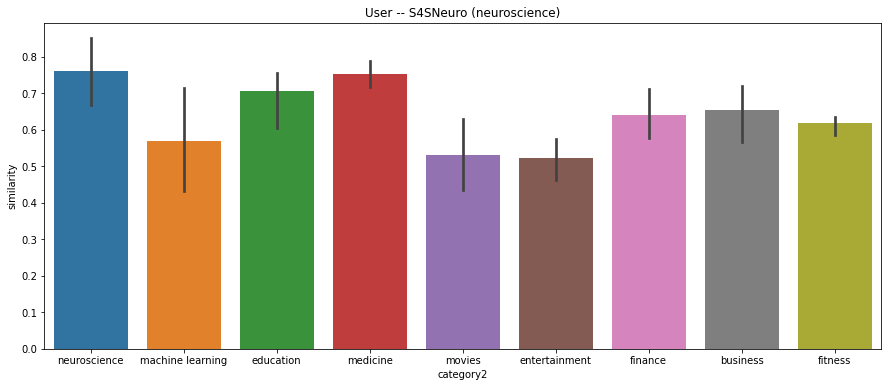

In [205]:
user = usernames[0]

plt.figure(figsize=(15,6))
sns.barplot(data=all_pairs[all_pairs["user1"]==user],x="category2",y="similarity")
plt.title(f"User -- {user} ({cat_map[user]})")
plt.show()

# Google News Word2Vec model